# A notebook for pileup study

In [1]:
import ROOT
f = ROOT.TFile('PileupAnalyzer.root')
folder_name = 'pileupAnalyzer'
c = ROOT.TCanvas('canv', 'canv', 600, 400)
leg = ROOT.TLegend(0.7,0.7,0.9,0.9)
ROOT.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.08/04


# 1. First part is for sanity check

Here we are looking at the energy of the decay positron, energy of the gamma from radiative decay and the energy deposition. This file has 80,000 muon gas guns to exaggerate the pileup effect.

In [2]:
ePrimary = f.Get('{}/ePrimary'.format(folder_name))
eGammaPrimary = f.Get('{}/eGammaPrimary'.format(folder_name))
eDep = f.Get('{}/eDep'.format(folder_name))
tree = f.Get('{}/tree'.format(folder_name))

In [3]:
def draw_both():
    eDep.Draw()
    eGammaPrimary.Draw("sames")
    ePrimary.Draw("sames")
    c.SetLogy()
    c.Draw()

In [4]:
def set_style():
    ePrimary.SetLineColor(1)
    eGammaPrimary.SetLineColor(2)
    eDep.SetLineColor(4)

In [5]:
def draw_legend():
    leg.AddEntry(ePrimary,ePrimary.GetName(),"l")
    leg.AddEntry(eGammaPrimary,eGammaPrimary.GetName(),"l")
    leg.AddEntry(eDep,eDep.GetName(),"l")
    leg.Draw()

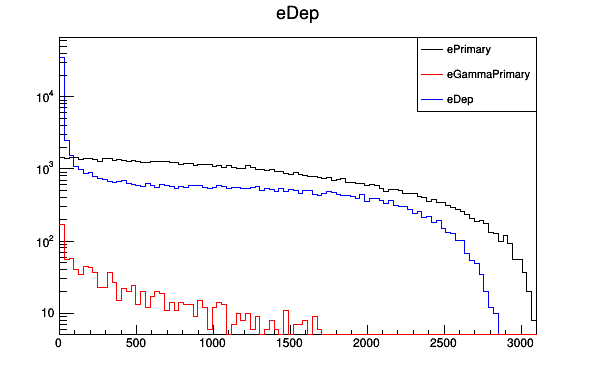

In [6]:
set_style()
draw_both()
draw_legend()

It is very interesting to see that the radiative gamma has an energy up to 1.7 GeV.

Tired of looking at the ROOT plots, let's try another tool in python developed for data analysis: pandas.

# 2. Now let's try to use pandas to study pileup effect

In [7]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10 # sets default plot size

## 2.1 Here we migrate our data from ROOT TTree to pandas's DataFrame.

In [8]:
data_rows = []
for entry in tree:
    data_rows.append([entry.caloNum, entry.timeTruth, entry.eTruth,
                                          entry.timeHit, entry.eDep])
# create the analysis DataFrame
df = pd.DataFrame(data_rows, columns=['calo_num', 'time_truth', 'e_truth', 'time_hit', 'e_dep'])
df.head(10)

,calo_num,time_truth,e_truth,time_hit,e_dep
0,1,2597.835227,233.450529,2599.191650,220.973088
1,21,8286.316566,1105.812331,8306.015625,288.984265
2,2,9322.758446,827.560053,9326.403320,796.611667
3,-1,5326.117760,277.998508,-1.000000,0.000000
4,-1,70378.807908,131.867443,-1.000000,0.000000
5,5,23313.139473,2080.672464,23321.103516,1909.333509
6,13,88756.855815,1287.999556,88765.953125,2.004961
7,5,60222.901108,229.558478,60226.902344,14.315173
8,4,21319.802924,1963.313063,21329.414062,1110.598750
9,7,9008.522913,1146.828198,9032.354492,130.466428


Here, $calo\_num = -1$ means there is no calo hit (evident by the zero e_dep).

## Let's look at the histograms

In pandas, it is way simpler.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131cadc90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x132754450>]], dtype=object)

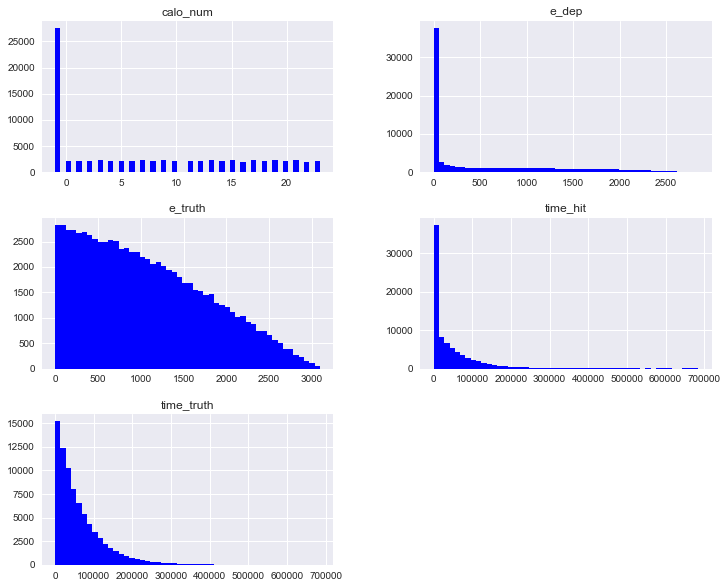

In [9]:
df.hist(layout=(3,2),bins=50,color='blue')

## 2.1 remove events with no hits and sort the rest according to the calo_num and then time_truth

In [10]:
df = df[df.calo_num>-1]
df = df.sort_values(['calo_num','time_truth'])
df = df.reset_index(drop=True)
df.head(10)

,calo_num,time_truth,e_truth,time_hit,e_dep
0,0,115.871234,293.399686,118.182472,125.575507
1,0,122.548781,858.783237,126.320602,769.521276
2,0,186.342021,1436.879928,190.300842,1325.108935
3,0,188.854145,791.989991,192.108627,763.625368
4,0,190.213433,434.357860,191.589844,414.831847
5,0,195.316774,1053.989131,214.105499,274.225989
6,0,208.369221,1119.362785,217.130219,617.859847
7,0,218.663106,555.463273,221.481232,536.268886
8,0,250.116720,139.261601,298.500061,2.107877
9,0,263.774723,267.584581,264.932587,71.072469


## 2.2 Let's look only at calo 00 and look at the time between positron events

First we calculate a variable $dt\_last = t\_current - t\_previous$.

In [11]:
calo00 = df[df.calo_num==0]
calo00 = calo00.drop('calo_num', 1)
calo00['dt_next'] = calo00['time_truth'].diff(1).shift(-1)
calo00['dt_previous'] = calo00['dt_next'].shift(1)
#calo00 = calo00.replace('NaN',0)
calo00 = calo00.reset_index(drop=True)
calo00.head(10)

,time_truth,e_truth,time_hit,e_dep,dt_next,dt_previous
0,115.871234,293.399686,118.182472,125.575507,6.677546,NaN
1,122.548781,858.783237,126.320602,769.521276,63.793241,6.677546
2,186.342021,1436.879928,190.300842,1325.108935,2.512124,63.793241
3,188.854145,791.989991,192.108627,763.625368,1.359288,2.512124
4,190.213433,434.357860,191.589844,414.831847,5.103341,1.359288
5,195.316774,1053.989131,214.105499,274.225989,13.052446,5.103341
6,208.369221,1119.362785,217.130219,617.859847,10.293885,13.052446
7,218.663106,555.463273,221.481232,536.268886,31.453614,10.293885
8,250.116720,139.261601,298.500061,2.107877,13.658003,31.453614
9,263.774723,267.584581,264.932587,71.072469,103.446477,13.658003


Let's look at the time distribution and the energy distribution again.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132a9ca10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13344a050>]], dtype=object)

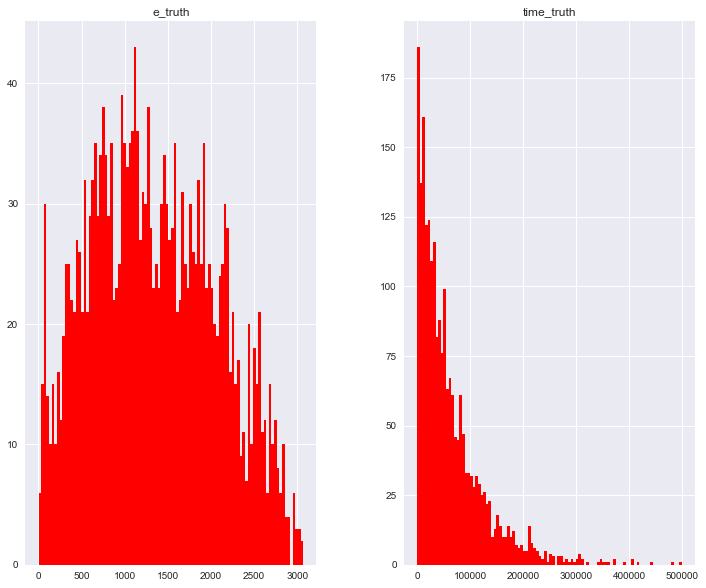

In [12]:
calo00.hist(['time_truth','e_truth'],bins=100,color='red')

## 2.3 Add another column to show that an event is a pileup to the previous event

In [13]:
calo00['is_pileup'] = calo00.dt_previous < 5
calo00.head(15)

,time_truth,e_truth,time_hit,e_dep,dt_next,dt_previous,is_pileup
0,115.871234,293.399686,118.182472,125.575507,6.677546,NaN,False
1,122.548781,858.783237,126.320602,769.521276,63.793241,6.677546,False
2,186.342021,1436.879928,190.300842,1325.108935,2.512124,63.793241,False
3,188.854145,791.989991,192.108627,763.625368,1.359288,2.512124,True
4,190.213433,434.357860,191.589844,414.831847,5.103341,1.359288,True
5,195.316774,1053.989131,214.105499,274.225989,13.052446,5.103341,False
6,208.369221,1119.362785,217.130219,617.859847,10.293885,13.052446,False
7,218.663106,555.463273,221.481232,536.268886,31.453614,10.293885,False
8,250.116720,139.261601,298.500061,2.107877,13.658003,31.453614,False
9,263.774723,267.584581,264.932587,71.072469,103.446477,13.658003,False


## 2.4 Add another column to indicate the first event index in case of pileups 

In [14]:
calo00['index'] = calo00[['is_pileup']].apply(lambda x: x.name -1 if x.bool() else x.name, axis =1)
calo00.head(10)

,time_truth,e_truth,time_hit,e_dep,dt_next,dt_previous,is_pileup,index
0,115.871234,293.399686,118.182472,125.575507,6.677546,NaN,False,0
1,122.548781,858.783237,126.320602,769.521276,63.793241,6.677546,False,1
2,186.342021,1436.879928,190.300842,1325.108935,2.512124,63.793241,False,2
3,188.854145,791.989991,192.108627,763.625368,1.359288,2.512124,True,2
4,190.213433,434.357860,191.589844,414.831847,5.103341,1.359288,True,3
5,195.316774,1053.989131,214.105499,274.225989,13.052446,5.103341,False,5
6,208.369221,1119.362785,217.130219,617.859847,10.293885,13.052446,False,6
7,218.663106,555.463273,221.481232,536.268886,31.453614,10.293885,False,7
8,250.116720,139.261601,298.500061,2.107877,13.658003,31.453614,False,8
9,263.774723,267.584581,264.932587,71.072469,103.446477,13.658003,False,9


### This method works fine for the double pile but not for the multiple pileups in general. For example, if you look at the entry no.4, the index should be 2 because it is the 3rd pulse in a triple pileup. Additional works have to be done below.

## 2.5 Define another variable index\_previous to help with the pulse_index assigning

In [15]:
calo00['index_previous'] = calo00['index'].diff(1)
calo00.head(10)

,time_truth,e_truth,time_hit,e_dep,dt_next,dt_previous,is_pileup,index,index_previous
0,115.871234,293.399686,118.182472,125.575507,6.677546,NaN,False,0,NaN
1,122.548781,858.783237,126.320602,769.521276,63.793241,6.677546,False,1,1.0
2,186.342021,1436.879928,190.300842,1325.108935,2.512124,63.793241,False,2,1.0
3,188.854145,791.989991,192.108627,763.625368,1.359288,2.512124,True,2,0.0
4,190.213433,434.357860,191.589844,414.831847,5.103341,1.359288,True,3,1.0
5,195.316774,1053.989131,214.105499,274.225989,13.052446,5.103341,False,5,2.0
6,208.369221,1119.362785,217.130219,617.859847,10.293885,13.052446,False,6,1.0
7,218.663106,555.463273,221.481232,536.268886,31.453614,10.293885,False,7,1.0
8,250.116720,139.261601,298.500061,2.107877,13.658003,31.453614,False,8,1.0
9,263.774723,267.584581,264.932587,71.072469,103.446477,13.658003,False,9,1.0


Here you can see that for entry number 4, the column index_previous is not 0 (for a pileup event it should be 0). 

## 2.6 Define a function to return the correct index for misidentified triple pileup

In [16]:
def assign_pulse_index(row):
    if(row['is_pileup']==True and row['index_previous']>0):
        return row['index']-1
    else:
        return row['index']

In [17]:
calo00['pulse_index'] = calo00.apply(assign_pulse_index, axis =1)
calo00.head(10)

,time_truth,e_truth,time_hit,e_dep,dt_next,dt_previous,is_pileup,index,index_previous,pulse_index
0,115.871234,293.399686,118.182472,125.575507,6.677546,NaN,False,0,NaN,0
1,122.548781,858.783237,126.320602,769.521276,63.793241,6.677546,False,1,1.0,1
2,186.342021,1436.879928,190.300842,1325.108935,2.512124,63.793241,False,2,1.0,2
3,188.854145,791.989991,192.108627,763.625368,1.359288,2.512124,True,2,0.0,2
4,190.213433,434.357860,191.589844,414.831847,5.103341,1.359288,True,3,1.0,2
5,195.316774,1053.989131,214.105499,274.225989,13.052446,5.103341,False,5,2.0,5
6,208.369221,1119.362785,217.130219,617.859847,10.293885,13.052446,False,6,1.0,6
7,218.663106,555.463273,221.481232,536.268886,31.453614,10.293885,False,7,1.0,7
8,250.116720,139.261601,298.500061,2.107877,13.658003,31.453614,False,8,1.0,8
9,263.774723,267.584581,264.932587,71.072469,103.446477,13.658003,False,9,1.0,9


Now the pulse\_index column has the value that what we expected. __Notice that we need to repeat this procedure for quadruple pileup. Since the rate is very low, I will skip it for now.__
Now we do not need the column index and index_previous and can drop them.

In [18]:
calo00 = calo00.drop(['index','index_previous'],1)
calo00.head(10)

,time_truth,e_truth,time_hit,e_dep,dt_next,dt_previous,is_pileup,pulse_index
0,115.871234,293.399686,118.182472,125.575507,6.677546,NaN,False,0
1,122.548781,858.783237,126.320602,769.521276,63.793241,6.677546,False,1
2,186.342021,1436.879928,190.300842,1325.108935,2.512124,63.793241,False,2
3,188.854145,791.989991,192.108627,763.625368,1.359288,2.512124,True,2
4,190.213433,434.357860,191.589844,414.831847,5.103341,1.359288,True,2
5,195.316774,1053.989131,214.105499,274.225989,13.052446,5.103341,False,5
6,208.369221,1119.362785,217.130219,617.859847,10.293885,13.052446,False,6
7,218.663106,555.463273,221.481232,536.268886,31.453614,10.293885,False,7
8,250.116720,139.261601,298.500061,2.107877,13.658003,31.453614,False,8
9,263.774723,267.584581,264.932587,71.072469,103.446477,13.658003,False,9


# 3. Now it's analysis time!

# 3.1 Let's group the data using pulse_index

In [19]:
calo00_bypulse = calo00.groupby('pulse_index')

## 3.1 Then create the pileup cluster energy list

In [20]:
e_pileup= calo00_bypulse['e_truth'].aggregate(np.sum)
e_pileup.head()

pulse_index
0     293.399686
1     858.783237
2    2663.227779
5    1053.989131
6    1119.362785
Name: e_truth, dtype: float64

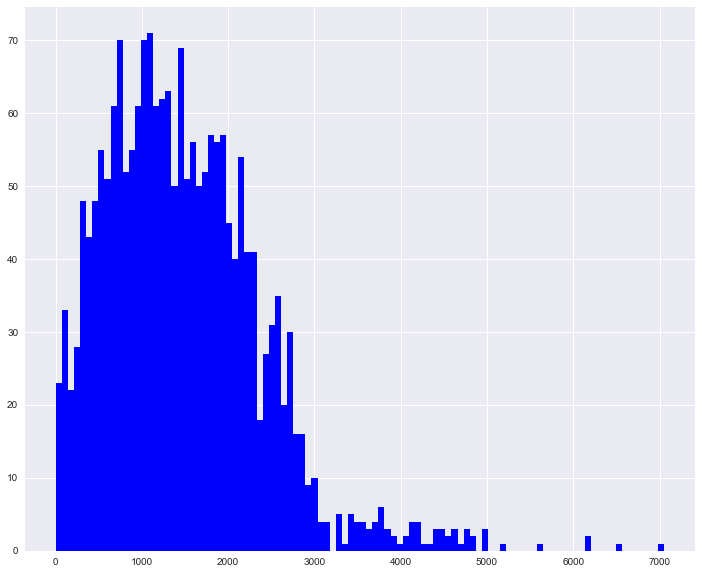

In [21]:
e_pileup.hist(bins=100,color='blue')

## 3.2 Cluster energy (no pileup versus pileup)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1323db650>], dtype=object)

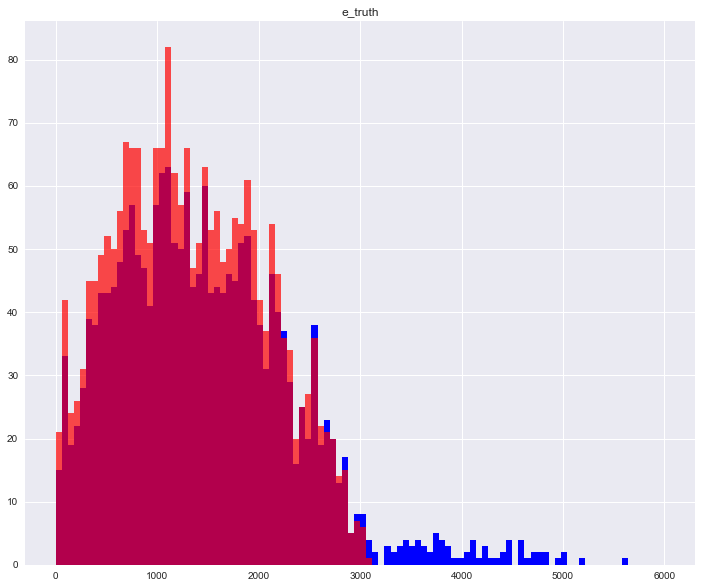

In [22]:
fig, ax = plt.subplots()
e_pileup.hist(bins=100, range=[0,6000],color='blue', ax=ax)
calo00.hist('e_truth',bins=100,range=[0,6000],color='red',alpha=0.7,ax=ax)

## 3.3 Cluster time

In [23]:
time_pileup = calo00_bypulse['time_truth'].aggregate(np.mean)
time_pileup.head()

pulse_index
0    115.871234
1    122.548781
2    188.469866
5    195.316774
6    208.369221
Name: time_truth, dtype: float64

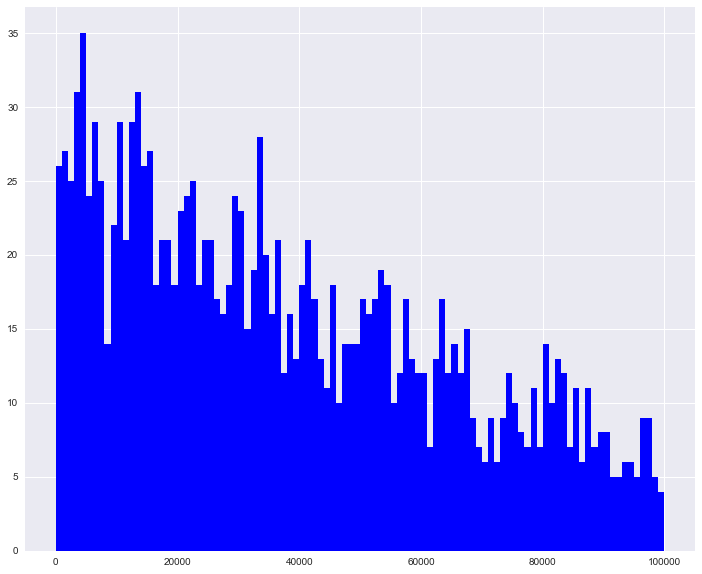

In [24]:
time_pileup.hist(bins=100,range=[0,100000],color='blue')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134bcb850>]], dtype=object)

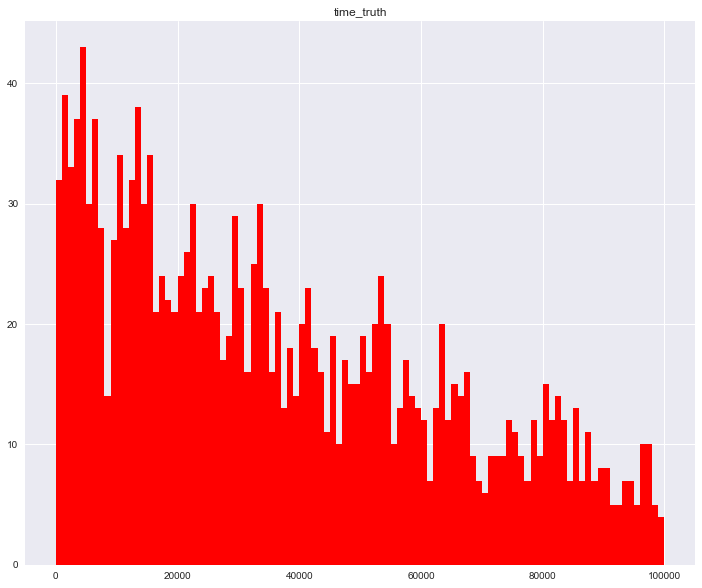

In [25]:
calo00.hist('time_truth',bins=100,range=[0,100000],color='red')

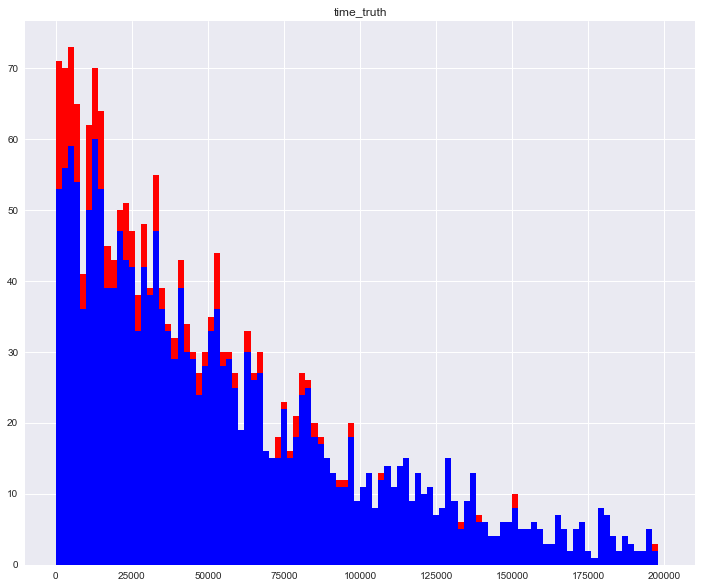

In [26]:
fig, ax = plt.subplots()
calo00.hist('time_truth',bins=100,range=[0,200000],ax=ax,color='red')
time_pileup.hist(bins=100,range=[0,200000],color='blue',ax=ax)

## 3.4 T-method histogram

In [27]:
calo00_T = calo00[calo00.e_truth>1800]
calo00_T_bypulse = calo00_T.groupby('pulse_index')

In [28]:
time_pileup_T = calo00_T_bypulse['time_truth'].aggregate(np.mean)
time_pileup_T.head()

pulse_index
15     497.579807
20     635.649686
28     834.128866
29     935.015905
34    1093.319868
Name: time_truth, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1354a2410>]], dtype=object)

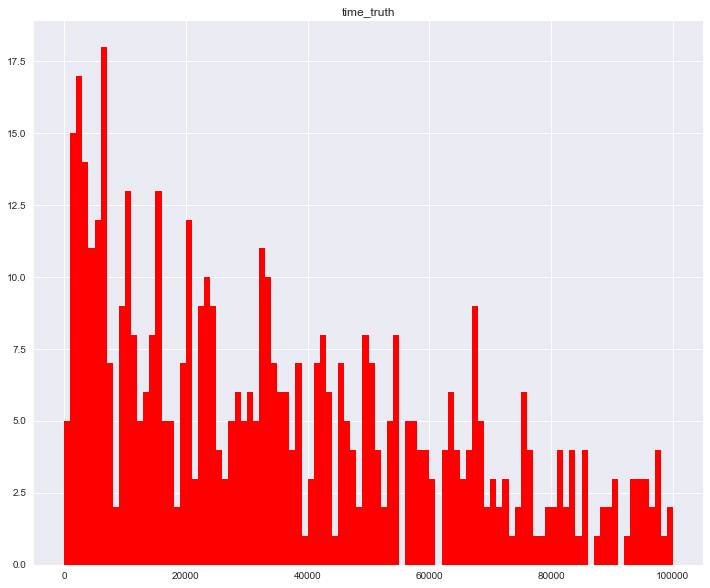

In [29]:
calo00_T.hist('time_truth',bins=100,color='red',range=[0,100000])

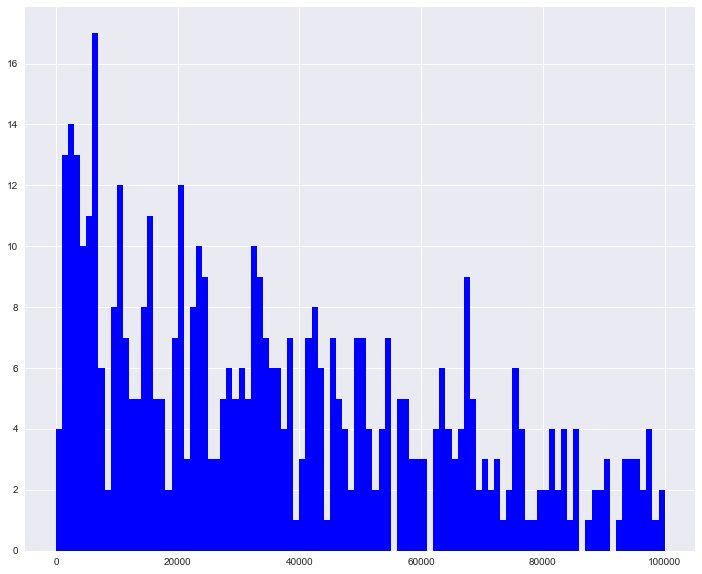

In [30]:
time_pileup_T.hist(bins=100,range=[0,100000],color='blue')

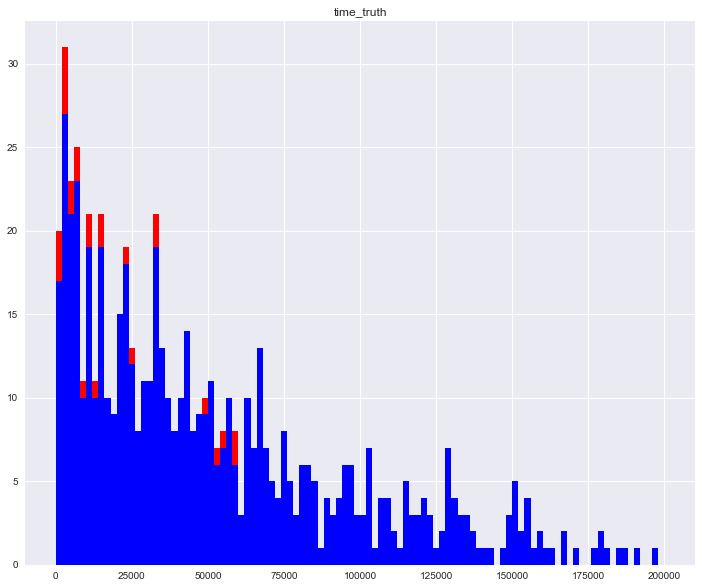

In [31]:
fig, ax = plt.subplots()
calo00_T.hist('time_truth',bins=100,range=[0,200000],ax=ax,color='red')
time_pileup_T.hist(bins=100,range=[0,200000],color='blue',ax=ax)